<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Library import</h2>
</div>

In [72]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import linear_model
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, log_loss
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [73]:
warnings.filterwarnings('ignore')

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Dataset Features</h2>
</div>

1. **ph**: pH of 1. water (0 to 14).

2. **Hardness**: Capacity of water to precipitate soap in mg/L.

3. **Solids**: Total dissolved solids in ppm.

4. **Chloramines**: Amount of Chloramines in ppm.

5. **Sulfate**: Amount of Sulfates dissolved in mg/L.

6. **Conductivity**: Electrical conductivity of water in μS/cm.

7. **Organic_carbon**: Amount of organic carbon in ppm.

8. **Trihalomethanes**: Amount of Trihalomethanes in μg/L.

9. **Turbidity**: Measure of light emiting property of water in NTU.

10. **Potability**: Indicates if water is safe for human consumption. Potable - 1 and Not potable - 0

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Load and analyse data</h2>
</div>

In [74]:
df = pd.read_csv("data/water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [75]:
df.shape

(3276, 10)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


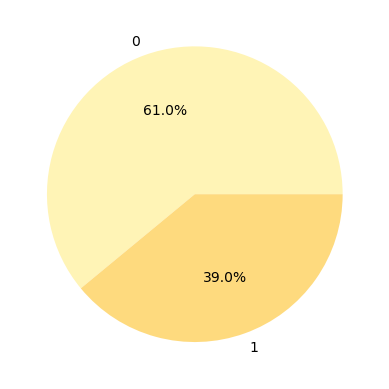

In [77]:
plt.pie(df.Potability.value_counts(), labels = ["0", "1"], colors = sns.color_palette("YlOrBr"), autopct = '%1.1f%%');

Primećujemo da je skup podataka poprilično nebalansiran. Stoga, kao ocenu modela nije dovoljno posmatrati samo tačnost, već i područje ispo ROC krive i kombinovanu f meru.

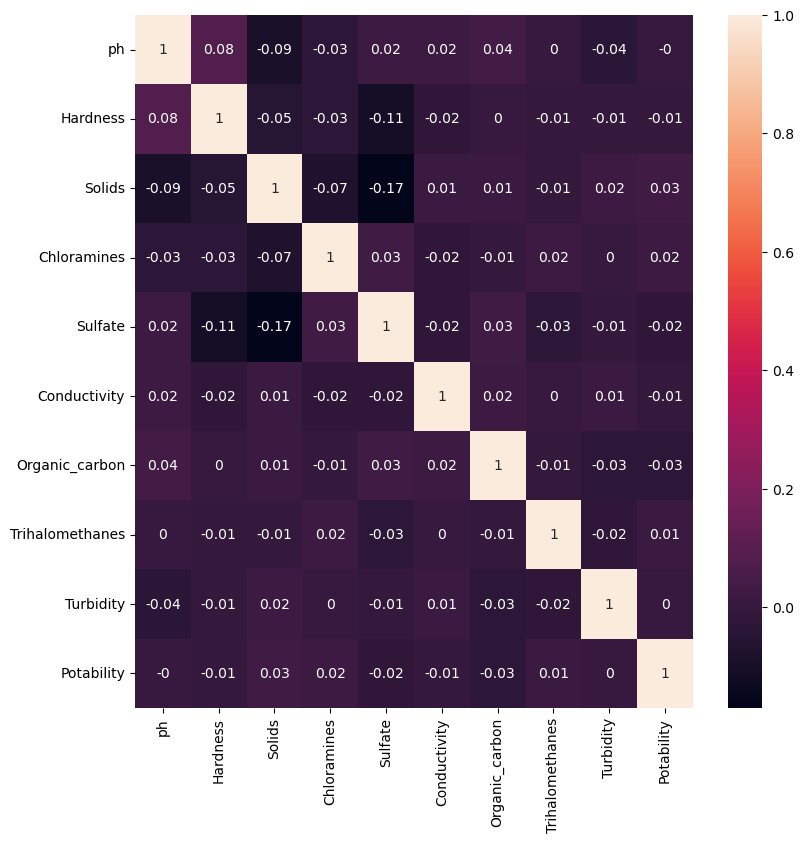

In [78]:
df_corr = df.corr()
df_corr = df_corr.apply(lambda x: round(x, 2))
fig, ax = plt.subplots(figsize = (9,9))
sns.heatmap(data=df_corr, annot=True, ax=ax);

Nizak nivo korelacije između atributa.

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Missing data visualization</h2>
</div>

In [79]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [80]:
df.isnull().mean()*100 

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

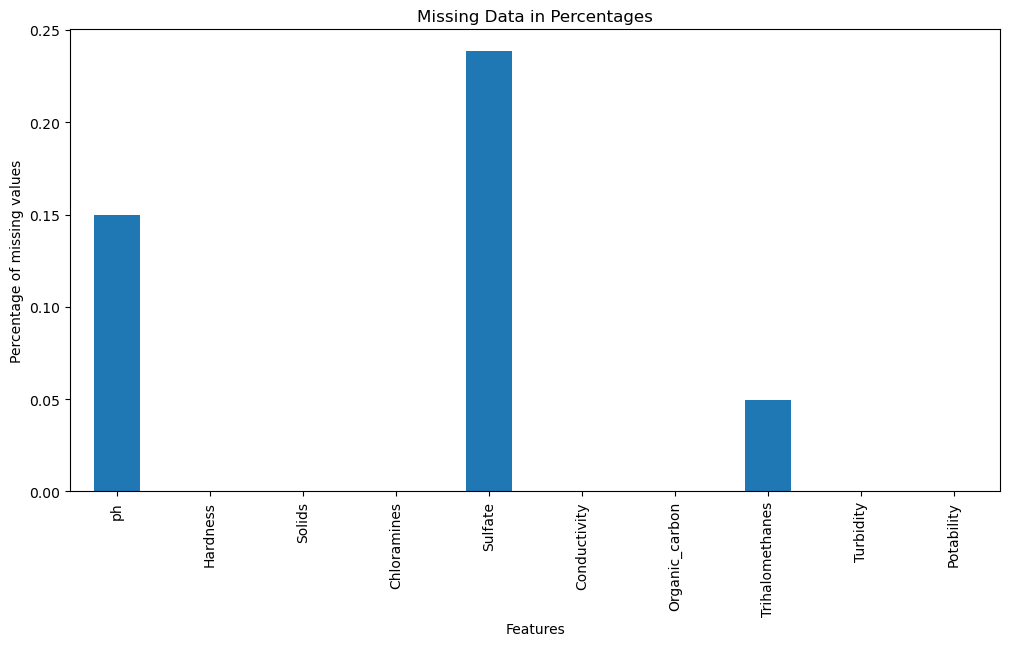

In [81]:
df.isnull().mean().plot.bar(figsize=(12,6)) 
plt.ylabel('Percentage of missing values') 
plt.xlabel('Features') 
plt.title('Missing Data in Percentages');

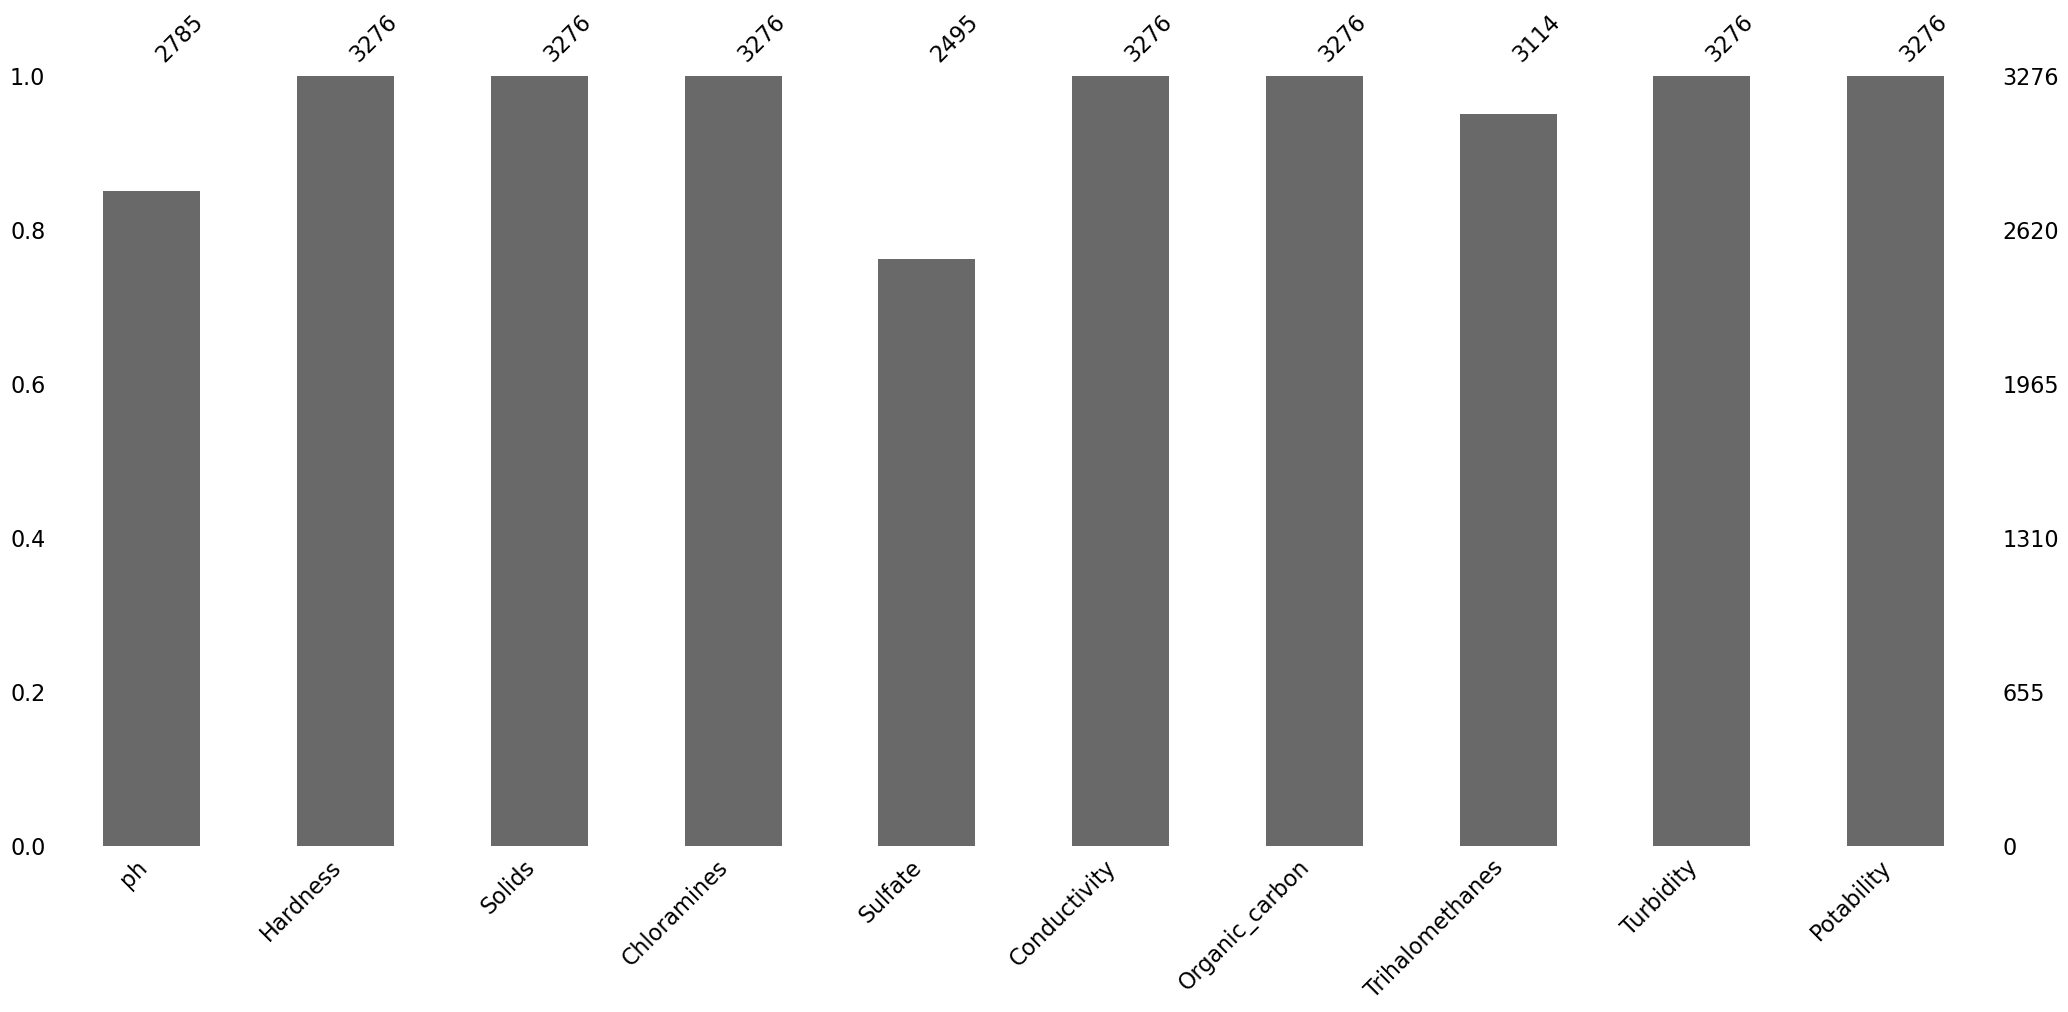

In [82]:
msno.bar(df);

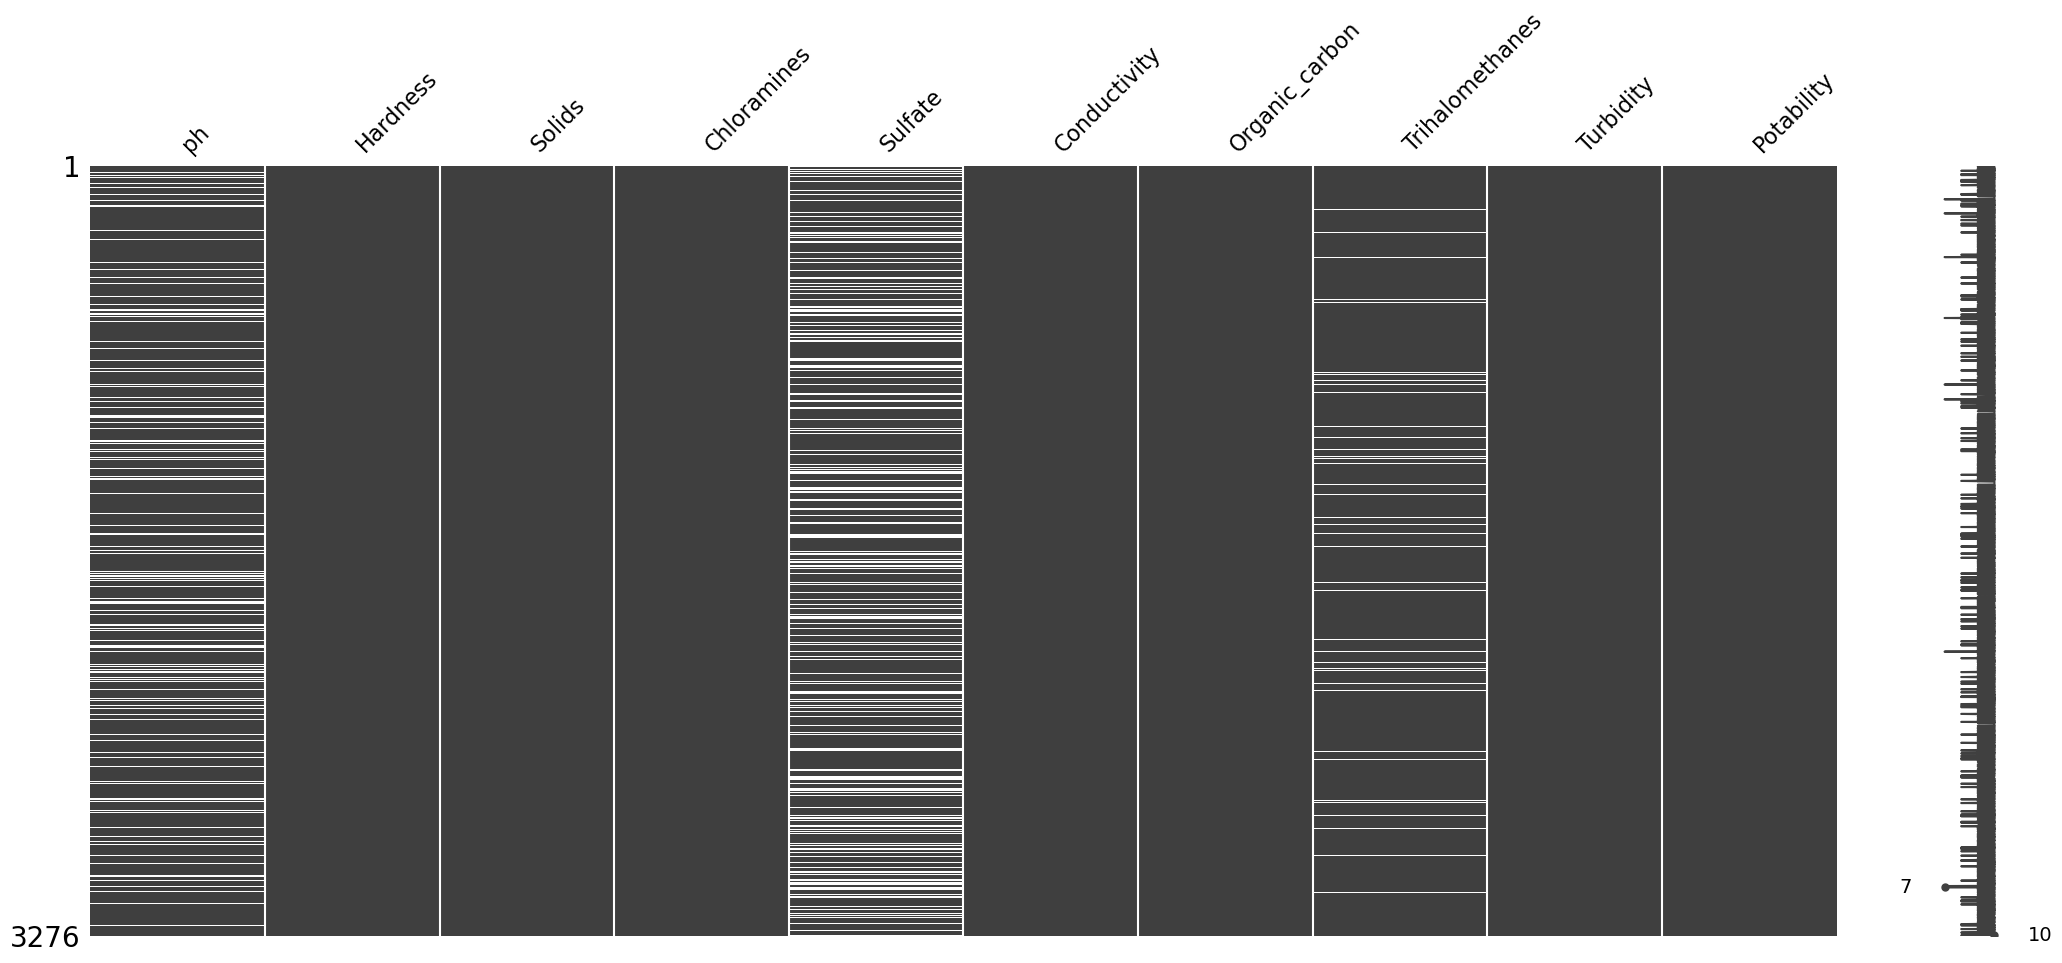

In [83]:
msno.matrix(df);

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Train-test split</h2>
</div>

In [84]:
np.random.seed(42)
X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

X_train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
233,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
831,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2658,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
2495,NaN,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
2603,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


In [85]:
X_train.isnull().mean()*100

ph                 15.076336
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            24.083969
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.847328
Turbidity           0.000000
dtype: float64

In [86]:
X_test.isnull().mean()*100

ph                 14.634146
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            22.865854
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     5.335366
Turbidity           0.000000
dtype: float64

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Deletion</h2>
</div>

In [87]:
X_train_del = X_train.dropna()
X_test_del = X_test.dropna()
idx = X_train_del.index
y_train_del = y_train.loc[idx]
idx = X_test_del.index
y_test_del = y_test.loc[idx]
print(f'Pre izbacivanja podataka imamo {df.shape[0]} instanci')

df_listwise = df.dropna()
print(f'Posle izbacivanja podataka imamo {df_listwise.shape[0]} instanci')

# to see how mnay instances we have lost
print(f'Izgubili smo {df.shape[0]-df_listwise.shape[0]} instanci, sto znaci %{round((df.shape[0]-df_listwise.shape[0])/ (float(df.shape[0])),2)*100} podataka je izgubljeno')

Pre izbacivanja podataka imamo 3276 instanci
Posle izbacivanja podataka imamo 2011 instanci
Izgubili smo 1265 instanci, sto znaci %39.0 podataka je izgubljeno


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Mean imputation</h2>
</div>

In [88]:
imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_mean = imputer.transform(X_train)

X_test_mean = imputer.transform(X_test)

In [89]:
X_train_mean_df = pd.DataFrame(data=X_train_mean, columns=X.columns)

X_train_mean_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.088976,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Median imputation</h2>
</div>

In [90]:
imputer = SimpleImputer(strategy='median')

imputer.fit(X_train)

X_train_median = imputer.transform(X_train)

X_test_median = imputer.transform(X_test)

In [91]:
X_train_median_df = pd.DataFrame(data=X_train_median, columns=X.columns)

X_train_median_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.021617,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Hot-deck imputation</h2>
</div>

In [92]:
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(X_train)

X_train_hd = imputer.transform(X_train)

X_test_hd = imputer.transform(X_test)

In [93]:
X_train_hd_df = pd.DataFrame(data=X_train_hd, columns=X.columns)

X_train_hd_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,0.000000,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Regression imputation</h2>
</div>

In [94]:
imputer = IterativeImputer(estimator=LinearRegression(), max_iter=1)

imputer.fit(X_train)

X_train_reg = imputer.transform(X_train)

X_test_reg = imputer.transform(X_test)

In [95]:
X_train_reg_df = pd.DataFrame(data=X_train_reg, columns=X.columns)

X_train_reg_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.124336,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
KNN imputation</h2>
</div>

In [96]:
imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_train)

X_train_knn = imputer.transform(X_train)

X_test_knn = imputer.transform(X_test)

In [97]:
X_train_knn_df = pd.DataFrame(data=X_train_knn, columns=X.columns)

X_train_knn_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.598431,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
MICE imputation</h2>
</div>

In [98]:
imputer = IterativeImputer(estimator=LinearRegression(), random_state=42, max_iter=20)

imputer.fit(X_train)

X_train_mice = imputer.transform(X_train)

X_test_mice = imputer.transform(X_test)

In [99]:
X_train_mice_df = pd.DataFrame(data=X_train_mice, columns=X.columns)

X_train_mice_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.623614,203.030141,17167.301297,6.049601,311.726288,410.243247,15.914500,65.021229,2.915166
1,6.684700,193.840931,34157.184474,9.876574,344.535407,498.063996,8.818757,66.659352,4.030660
2,6.836060,205.667718,18321.327502,6.712854,297.837188,494.484249,13.808923,70.714225,4.952508
3,7.124336,183.488839,12675.938962,9.777807,319.870584,482.445026,13.309723,46.853410,3.240419
4,6.406798,182.885137,17851.064021,7.462758,332.486731,398.779746,17.301617,64.070236,4.573968


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Standardizacija podataka</h2>
</div>

In [100]:
#Standardizacija nad deletion
scaler = StandardScaler()
scaler.fit(X_train_del)

X_train_del_std = pd.DataFrame(scaler.transform(X_train_del), columns=X_train_del.columns)
X_test_del_std = pd.DataFrame(scaler.transform(X_test_del), columns=X_test_del.columns)

#Standardizacija nad mean imputation
scaler = StandardScaler()
scaler.fit(X_train_mean_df)

X_train_mean_std = pd.DataFrame(scaler.transform(X_train_mean_df), columns=X_train_mean_df.columns)
X_test_mean_std = pd.DataFrame(scaler.transform(X_test_mean), columns=X_train_mean_df.columns)

#Standardizacija nad median imputation
scaler = StandardScaler()
scaler.fit(X_train_median_df)

X_train_median_std = pd.DataFrame(scaler.transform(X_train_median_df), columns=X_train_median_df.columns)
X_test_median_std = pd.DataFrame(scaler.transform(X_test_median), columns=X_train_median_df.columns)

#Standardizacija nad hot-deck imputation
scaler = StandardScaler()
scaler.fit(X_train_hd_df)

X_train_hd_std = pd.DataFrame(scaler.transform(X_train_hd_df), columns=X_train_hd_df.columns)
X_test_hd_std = pd.DataFrame(scaler.transform(X_test_hd), columns=X_train_hd_df.columns)

#Standardizacija nad jednostrukom regresijom
scaler = StandardScaler()
scaler.fit(X_train_reg_df)

X_train_reg_std = pd.DataFrame(scaler.transform(X_train_reg_df), columns=X_train_reg_df.columns)
X_test_reg_std = pd.DataFrame(scaler.transform(X_test_reg), columns=X_train_reg_df.columns)

#Standardizacija nad jednostrukom knn imputacijom
scaler = StandardScaler()
scaler.fit(X_train_knn_df)

X_train_knn_std = pd.DataFrame(scaler.transform(X_train_knn_df), columns=X_train_knn_df.columns)
X_test_knn_std = pd.DataFrame(scaler.transform(X_test_knn), columns=X_train_knn_df.columns)


#Standardizacija nad jednostrukom mice imputacijom
scaler = StandardScaler()
scaler.fit(X_train_mice_df)

X_train_mice_std = pd.DataFrame(scaler.transform(X_train_mice_df), columns=X_train_mice_df.columns)
X_test_mice_std = pd.DataFrame(scaler.transform(X_test_mice), columns=X_train_mice_df.columns)

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Primena klasifikacionih modela masinskog ucenja</h2>
</div>

In [101]:
testing = pd.DataFrame(columns=["Algoritam","Imputacija/Brisanje", "Kombinovana f mera", "Područje ispod ROC krive", "Accuracy"])
testing

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Decision Tree Classifier, kreiranje modela</h2>
</div>

In [102]:
np.random.seed(42)
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
# Podešavanje hiperparametara i kreiranje modela
params = {
            "criterion" : ["gini", "entropy"], 
            "splitter" : ["best", "random"], 
            "max_depth" : [20, 40, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4],  
        }

#Model za izbrisane podatke
model_del_dt = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_del_dt.fit(X_train_del_std, y_train_del)

#Model za mean
model_mean_dt = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mean_dt.fit(X_train_mean_std, y_train)

#Model za median
model_median_dt = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_median_dt.fit(X_train_median_std, y_train)

#Model za jednostruku imputaciju pomocu regresije
model_reg_dt = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_reg_dt.fit(X_train_reg_std, y_train)

#Model za jednostruku imputaciju pomocu knn
model_knn_dt = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_knn_dt.fit(X_train_knn_std, y_train)

#Model za mice
model_mice_dt = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mice_dt.fit(X_train_mice_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 40, None],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [3, 6],
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

In [103]:
roc_aucs = []
f1_mera = []
accs = []

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Deletion</h2>
</div>

In [104]:
pred = model_del_dt.predict(X_test_del_std)
f1 = f1_score(y_test_del, model_del_dt.predict(X_test_del_std))
auc = roc_auc_score(y_test_del, model_del_dt.predict(X_test_del_std))
acc = accuracy_score(y_test_del, model_del_dt.predict(X_test_del_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.510
Podrucje ispod ROC krive je: 0.585
Accuracy je: 0.596


In [105]:
testing.loc[-1] = ["Decision Tree","Brisanje", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Mean imputation</h2>
</div>

In [106]:
pred = model_mean_dt.predict(X_test_mean_std)
f1 = f1_score(y_test, model_mean_dt.predict(X_test_mean_std))
auc = roc_auc_score(y_test, model_mean_dt.predict(X_test_mean_std))
acc = accuracy_score(y_test, model_mean_dt.predict(X_test_mean_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.468
Podrucje ispod ROC krive je: 0.557
Accuracy je: 0.570


In [107]:
testing.loc[-1] = ["Decision Tree","Mean imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Median imputation</h2>
</div>

In [108]:
pred = model_median_dt.predict(X_test_median_std)
f1 = f1_score(y_test, model_median_dt.predict(X_test_median_std))
auc = roc_auc_score(y_test, model_median_dt.predict(X_test_median_std))
acc = accuracy_score(y_test, model_median_dt.predict(X_test_median_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.469
Podrucje ispod ROC krive je: 0.536
Accuracy je: 0.530


In [109]:
testing.loc[-1] = ["Decision Tree","Median imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Jednostruka regresija</h2>
</div>

In [110]:
pred = model_reg_dt.predict(X_test_reg_std)
f1 = f1_score(y_test, model_reg_dt.predict(X_test_reg_std))
auc = roc_auc_score(y_test, model_reg_dt.predict(X_test_reg_std))
acc = accuracy_score(y_test, model_reg_dt.predict(X_test_reg_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.522
Podrucje ispod ROC krive je: 0.598
Accuracy je: 0.601


In [111]:
testing.loc[-1] = ["Decision Tree","Jednostruka regresija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
KNN</h2>
</div>

In [112]:
pred = model_knn_dt.predict(X_test_knn_std)
f1 = f1_score(y_test, model_knn_dt.predict(X_test_knn_std))
auc = roc_auc_score(y_test, model_knn_dt.predict(X_test_knn_std))
acc = accuracy_score(y_test, model_knn_dt.predict(X_test_knn_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.523
Podrucje ispod ROC krive je: 0.607
Accuracy je: 0.619


In [113]:
testing.loc[-1] = ["Decision Tree","KNN imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
MICE</h2>
</div>

In [114]:
pred = model_mice_dt.predict(X_test_mice_std)
f1 = f1_score(y_test, model_mice_dt.predict(X_test_mice_std))
auc = roc_auc_score(y_test, model_mice_dt.predict(X_test_mice_std))
acc = accuracy_score(y_test, model_mice_dt.predict(X_test_mice_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.494
Podrucje ispod ROC krive je: 0.565
Accuracy je: 0.562


In [115]:
testing.loc[-1] = ["Decision Tree","MICE imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

In [116]:
testing

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy
0,Decision Tree,MICE imputacija,0.493827,0.564798,0.562500
1,Decision Tree,KNN imputacija,0.522901,0.607194,0.618902
2,Decision Tree,Jednostruka regresija,0.521898,0.597644,0.600610
3,Decision Tree,Median imputacija,0.468966,0.535970,0.530488
4,Decision Tree,Mean imputacija,0.467925,0.557496,0.570122
5,Decision Tree,Brisanje,0.510264,0.584871,0.595642


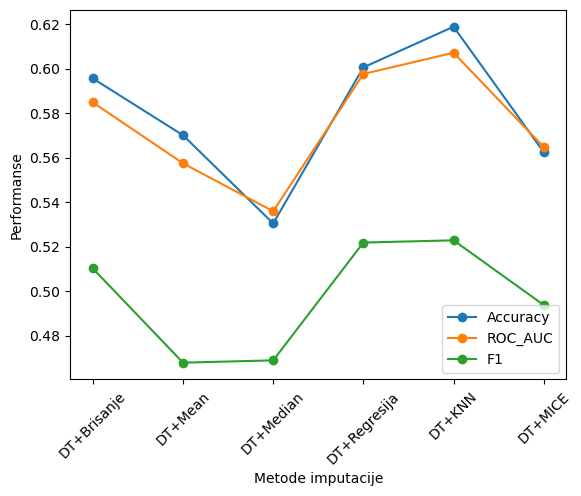

In [117]:
metode = ['DT+Brisanje', 'DT+Mean', 'DT+Median', 'DT+Regresija', 'DT+KNN', 'DT+MICE']

plt.plot(metode, accs, marker='o', label='Accuracy')
plt.plot(metode, roc_aucs, marker='o', label='ROC_AUC')
plt.plot(metode, f1_mera, marker='o', label='F1')
plt.xlabel("Metode imputacije")
plt.ylabel("Performanse")
plt.xticks(rotation=45) 
plt.legend()
plt.show()

Može se primetiti da se kombinovana f-mera, područje ispod ROC krive i tačnost najviše povećavaju kada se primeni KNN imputacija. S druge strane, najniža kombinovana f-mera i područje ispod ROC krive su dobijene primenom mediane kao imputacije i algoritma odlučivanja.

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Random Forest Classifier, kreiranje modela</h2>
</div>

In [118]:
y_train_del.shape, X_train_del_std.shape

((1598,), (1598, 9))

In [119]:
np.random.seed(42)
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
# Podešavanje hiperparametara i kreiranje modela
params = {
            "n_estimators" : [100, 200], 
            "criterion" : ["gini", "entropy"], 
            "max_depth" : [15, 25, None],
            "min_samples_split" : [3, 6], 
            "min_samples_leaf" : [2, 4]
}

#Model za izbrisane podatke
model_del = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_del.fit(X_train_del_std, y_train_del)

#Model za mean
model_mean = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mean.fit(X_train_mean_std, y_train)

#Model za median
model_median = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_median.fit(X_train_median_std, y_train)

#Model za jednostruku imputaciju pomocu regresije
model_reg = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_reg.fit(X_train_reg_std, y_train)

#Model za jednostruku imputaciju pomocu knn
model_knn = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_knn.fit(X_train_knn_std, y_train)

#Model za mice
model_mice = GridSearchCV(estimator = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, random_state=42), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mice.fit(X_train_mice_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 25, None],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [3, 6],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [120]:
roc_aucs = []
f1_mera = []
accs = []

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Deletion</h2>
</div>

In [121]:
pred = model_del.predict(X_test_del_std)
f1 = f1_score(y_test_del, model_del.predict(X_test_del_std))
auc = roc_auc_score(y_test_del, model_del.predict(X_test_del_std))
acc = accuracy_score(y_test_del, model_del.predict(X_test_del_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest","Brisanje", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.539
Podrucje ispod ROC krive je: 0.647
Accuracy je: 0.685


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Mean imputation</h2>
</div>

In [122]:
pred = model_mean.predict(X_test_mean_std)
f1 = f1_score(y_test, model_mean.predict(X_test_mean_std))
auc = roc_auc_score(y_test, model_mean.predict(X_test_mean_std))
acc = accuracy_score(y_test, model_mean.predict(X_test_mean_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest","Mean imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.465
Podrucje ispod ROC krive je: 0.616
Accuracy je: 0.677


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Median imputation</h2>
</div>

In [123]:
pred = model_median.predict(X_test_median_std)
f1 = f1_score(y_test, model_median.predict(X_test_median_std))
auc = roc_auc_score(y_test, model_median.predict(X_test_median_std))
acc = accuracy_score(y_test, model_median.predict(X_test_median_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest","Median imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.446
Podrucje ispod ROC krive je: 0.607
Accuracy je: 0.671


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Jednostruka regresija</h2>
</div>

In [124]:
pred = model_reg.predict(X_test_reg_std)
f1 = f1_score(y_test, model_reg.predict(X_test_reg_std))
auc = roc_auc_score(y_test, model_reg.predict(X_test_reg_std))
acc = accuracy_score(y_test, model_reg.predict(X_test_reg_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest","Jednostruka regresija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.501
Podrucje ispod ROC krive je: 0.632
Accuracy je: 0.684


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
KNN</h2>
</div>

In [125]:
pred = model_knn.predict(X_test_knn_std)
f1 = f1_score(y_test, model_knn.predict(X_test_knn_std))
auc = roc_auc_score(y_test, model_knn.predict(X_test_knn_std))
acc = accuracy_score(y_test, model_knn.predict(X_test_knn_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest","KNN imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.445
Podrucje ispod ROC krive je: 0.610
Accuracy je: 0.677


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
MICE</h2>
</div>

In [126]:
pred = model_mice.predict(X_test_mice_std)
f1 = f1_score(y_test, model_mice.predict(X_test_mice_std))
auc = roc_auc_score(y_test, model_mice.predict(X_test_mice_std))
acc = accuracy_score(y_test, model_mice.predict(X_test_mice_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

testing.loc[-1] = ["Random Forest","MICE imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

Kombinovana F mera je : 0.501
Podrucje ispod ROC krive je: 0.632
Accuracy je: 0.684


In [127]:
testing

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy
0,Random Forest,MICE imputacija,0.501205,0.631804,0.684451
1,Random Forest,KNN imputacija,0.445026,0.609860,0.676829
2,Random Forest,Jednostruka regresija,0.501205,0.631804,0.684451
3,Random Forest,Median imputacija,0.446154,0.606677,0.670732
4,Random Forest,Mean imputacija,0.464646,0.615709,0.676829
5,Random Forest,Brisanje,0.539007,0.647129,0.685230
6,Decision Tree,MICE imputacija,0.493827,0.564798,0.562500
7,Decision Tree,KNN imputacija,0.522901,0.607194,0.618902
8,Decision Tree,Jednostruka regresija,0.521898,0.597644,0.600610
9,Decision Tree,Median imputacija,0.468966,0.535970,0.530488


Razlog za ovo je verovatno taj sto podaci nisu dovoljno korelisani

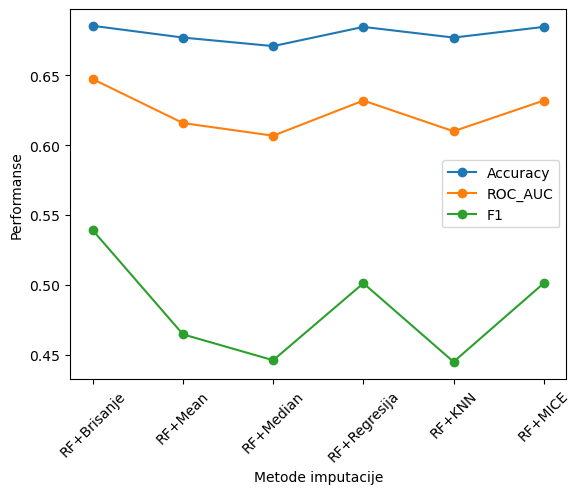

In [128]:
metode = ['RF+Brisanje', 'RF+Mean', 'RF+Median', 'RF+Regresija', 'RF+KNN', 'RF+MICE']

plt.plot(metode, accs, marker='o', label='Accuracy')
plt.plot(metode, roc_aucs, marker='o', label='ROC_AUC')
plt.plot(metode, f1_mera, marker='o', label='F1')
plt.xlabel("Metode imputacije")
plt.ylabel("Performanse")
plt.xticks(rotation=45) 
plt.legend()
plt.show()

Može se primetiti da se najbolja kombinovana f-mera, područje ispod ROC krive i tačnost postižu kada se primeni brisanje nedostajućih vrednosti. Međutim, ovo nije uvek preporučljivo, jer može dovesti do gubitka velikog dela informacija. Takođe, može se primetiti da se kombinovana f-mera i područje ispod ROC krive najmanje povećavaju kada se primeni KNN imputacija, dok su, posle brisanja, najviše postignute primenom MICE imputacije i jednostruke regresije.

S druge strane, mediana i srednja vrednost kao imputacije ne daju tako dobre rezultate kao ostale strategije.

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Logistic Regression Classifier, kreiranje modela</h2>
</div>

In [129]:
roc_aucs = []
f1_mera = []
accs = []

params = [
            {
                "penalty" : ['l2'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["sag"], 
                "max_iter" : [100, 200]
            },
            {
                "penalty" : ['l1'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["saga"], 
                "max_iter" : [100, 200]
            }
]
#Model za izbrisane podatke
model_del_lr = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_del_lr.fit(X_train_del_std, y_train_del)

#Model za mean
model_mean_lr = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mean_lr.fit(X_train_mean_std, y_train)

#Model za median
model_median_lr = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_median_lr.fit(X_train_median_std, y_train)

#Model za jednostruku imputaciju pomocu regresije
model_reg_lr = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_reg_lr.fit(X_train_reg_std, y_train)

#Model za jednostruku imputaciju pomocu knn
model_knn_lr = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_knn_lr.fit(X_train_knn_std, y_train)

#Model za mice
model_mice_lr = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = cv, 
                   n_jobs = -1, scoring = "roc_auc")
model_mice_lr.fit(X_train_mice_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10.0], 'max_iter': [100, 200],
                          'penalty': ['l2'], 'solver': ['sag']},
                         {'C': [0.01, 0.1, 1.0, 10.0], 'max_iter': [100, 200],
                          'penalty': ['l1'], 'solver': ['saga']}],
             scoring='roc_auc')

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Deletion</h2>
</div>

In [130]:
pred = model_del_lr.predict(X_test_del_std)
f1 = f1_score(y_test_del, model_del_lr.predict(X_test_del_std))
auc = roc_auc_score(y_test_del, model_del_lr.predict(X_test_del_std))
acc = accuracy_score(y_test_del, model_del_lr.predict(X_test_del_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.566
Podrucje ispod ROC krive je: 0.500
Accuracy je: 0.395


In [131]:
testing.loc[-1] = ["Logistic Regression","Brisanje", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Mean imputation</h2>
</div>

In [132]:
pred = model_mean_lr.predict(X_test_mean_std)
f1 = f1_score(y_test, model_mean_lr.predict(X_test_mean_std))
auc = roc_auc_score(y_test, model_mean_lr.predict(X_test_mean_std))
acc = accuracy_score(y_test, model_mean_lr.predict(X_test_mean_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.418
Podrucje ispod ROC krive je: 0.497
Accuracy je: 0.500


In [133]:
testing.loc[-1] = ["Logistic Regression","Mean imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Median imputation</h2>
</div>

In [134]:
pred = model_median_lr.predict(X_test_median_std)
f1 = f1_score(y_test, model_median_lr.predict(X_test_median_std))
auc = roc_auc_score(y_test, model_median_lr.predict(X_test_median_std))
acc = accuracy_score(y_test, model_median_lr.predict(X_test_median_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.418
Podrucje ispod ROC krive je: 0.497
Accuracy je: 0.500


In [135]:
testing.loc[-1] = ["Logistic Regression","Median imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Jednostruka regresija</h2>
</div>

In [136]:
pred = model_reg_lr.predict(X_test_reg_std)
f1 = f1_score(y_test, model_reg_lr.predict(X_test_reg_std))
auc = roc_auc_score(y_test, model_reg_lr.predict(X_test_reg_std))
acc = accuracy_score(y_test, model_reg_lr.predict(X_test_reg_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.424
Podrucje ispod ROC krive je: 0.501
Accuracy je: 0.503


In [137]:
testing.loc[-1] = ["Logistic Regression","Jednostruka regresija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
KNN</h2>
</div>

In [138]:
pred = model_knn_lr.predict(X_test_knn_std)
f1 = f1_score(y_test, model_knn_lr.predict(X_test_knn_std))
auc = roc_auc_score(y_test, model_knn_lr.predict(X_test_knn_std))
acc = accuracy_score(y_test, model_knn_lr.predict(X_test_knn_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.418
Podrucje ispod ROC krive je: 0.495
Accuracy je: 0.498


In [139]:
testing.loc[-1] = ["Logistic Regression","KNN imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
MICE</h2>
</div>

In [140]:
pred = model_mice_lr.predict(X_test_mice_std)
f1 = f1_score(y_test, model_mice_lr.predict(X_test_mice_std))
auc = roc_auc_score(y_test, model_mice_lr.predict(X_test_mice_std))
acc = accuracy_score(y_test, model_mice_lr.predict(X_test_mice_std))

accs.append(acc)
roc_aucs.append(auc)
f1_mera.append(f1)

print("Kombinovana F mera je : %0.3f" %f1)
print("Podrucje ispod ROC krive je: %0.3f" %auc)
print("Accuracy je: %0.3f" %acc)

Kombinovana F mera je : 0.424
Podrucje ispod ROC krive je: 0.501
Accuracy je: 0.503


In [141]:
testing.loc[-1] = ["Logistic Regression","MICE imputacija", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

In [142]:
testing

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy
0,Logistic Regression,MICE imputacija,0.424028,0.500756,0.503049
1,Logistic Regression,KNN imputacija,0.417699,0.495444,0.498476
2,Logistic Regression,Jednostruka regresija,0.424028,0.500756,0.503049
3,Logistic Regression,Median imputacija,0.418440,0.496658,0.500000
4,Logistic Regression,Mean imputacija,0.418440,0.496658,0.500000
5,Logistic Regression,Brisanje,0.565972,0.500000,0.394673
6,Random Forest,MICE imputacija,0.501205,0.631804,0.684451
7,Random Forest,KNN imputacija,0.445026,0.609860,0.676829
8,Random Forest,Jednostruka regresija,0.501205,0.631804,0.684451
9,Random Forest,Median imputacija,0.446154,0.606677,0.670732


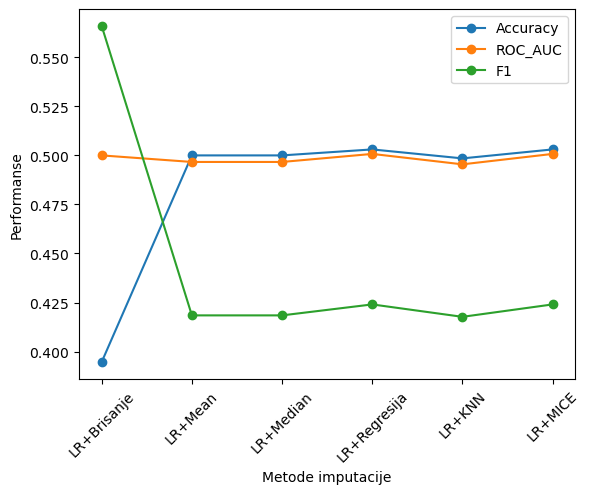

In [143]:
metode = ['LR+Brisanje', 'LR+Mean', 'LR+Median', 'LR+Regresija', 'LR+KNN', 'LR+MICE']

plt.plot(metode, accs, marker='o', label='Accuracy')
plt.plot(metode, roc_aucs, marker='o', label='ROC_AUC')
plt.plot(metode, f1_mera, marker='o', label='F1')
plt.xlabel("Metode imputacije")
plt.ylabel("Performanse")
plt.xticks(rotation=45) 
plt.legend()
plt.show()

U ovom slučaju, rezultati za Logistic Regression su znatno lošiji u poređenju sa Decision Tree i Random Forest algoritmima, sa kombinovanom f-merom oko 0.42 i accuracy od oko 0.5. Ovo ukazuje na to da Logistic Regression ne uspeva dobro da modeluje podatke u ovom slučaju. Jedan razlog za ovo je to što postoje interakcije među atributima koje model ne može uhvatiti linearnim odnosima. Takođe, imajući u vidu da su podaci nebalansirani, postoji mogućnost da je potrebno više tretmana neravnoteže klasa ili korišćenje drugih tehnika za ovu vrstu problema. Brisanje nedostajućih podataka kao strategija imputacije takođe može dovesti do pogoršanja performansi modela, kao što je slučaj ovde sa kombinovanom f-merom od 0.57, što ukazuje na to da postoji gubitak informacija zbog izbacivanja podataka.

In [144]:
DFAccuracy = testing.sort_values("Accuracy",ascending=False)
DFAccuracy

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy
11,Random Forest,Brisanje,0.539007,0.647129,0.685230
8,Random Forest,Jednostruka regresija,0.501205,0.631804,0.684451
6,Random Forest,MICE imputacija,0.501205,0.631804,0.684451
10,Random Forest,Mean imputacija,0.464646,0.615709,0.676829
7,Random Forest,KNN imputacija,0.445026,0.609860,0.676829
9,Random Forest,Median imputacija,0.446154,0.606677,0.670732
13,Decision Tree,KNN imputacija,0.522901,0.607194,0.618902
14,Decision Tree,Jednostruka regresija,0.521898,0.597644,0.600610
17,Decision Tree,Brisanje,0.510264,0.584871,0.595642
16,Decision Tree,Mean imputacija,0.467925,0.557496,0.570122


In [145]:
DFPodrucjeIspodROCKrive = testing.sort_values("Područje ispod ROC krive",ascending=False)
DFPodrucjeIspodROCKrive

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy
11,Random Forest,Brisanje,0.539007,0.647129,0.685230
8,Random Forest,Jednostruka regresija,0.501205,0.631804,0.684451
6,Random Forest,MICE imputacija,0.501205,0.631804,0.684451
10,Random Forest,Mean imputacija,0.464646,0.615709,0.676829
7,Random Forest,KNN imputacija,0.445026,0.609860,0.676829
13,Decision Tree,KNN imputacija,0.522901,0.607194,0.618902
9,Random Forest,Median imputacija,0.446154,0.606677,0.670732
14,Decision Tree,Jednostruka regresija,0.521898,0.597644,0.600610
17,Decision Tree,Brisanje,0.510264,0.584871,0.595642
12,Decision Tree,MICE imputacija,0.493827,0.564798,0.562500


In [146]:
DFKombinovanaFMera = testing.sort_values("Kombinovana f mera",ascending=False)
DFKombinovanaFMera

,Algoritam,Imputacija/Brisanje,Kombinovana f mera,Područje ispod ROC krive,Accuracy
5,Logistic Regression,Brisanje,0.565972,0.500000,0.394673
11,Random Forest,Brisanje,0.539007,0.647129,0.685230
13,Decision Tree,KNN imputacija,0.522901,0.607194,0.618902
14,Decision Tree,Jednostruka regresija,0.521898,0.597644,0.600610
17,Decision Tree,Brisanje,0.510264,0.584871,0.595642
6,Random Forest,MICE imputacija,0.501205,0.631804,0.684451
8,Random Forest,Jednostruka regresija,0.501205,0.631804,0.684451
12,Decision Tree,MICE imputacija,0.493827,0.564798,0.562500
15,Decision Tree,Median imputacija,0.468966,0.535970,0.530488
16,Decision Tree,Mean imputacija,0.467925,0.557496,0.570122


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Zaključak</h2>
</div>

Na kraju se može zaključiti da je najbolji rezultat za kombinovanu f-meru i područje ispod ROC krive postignut korišćenjem algoritma Random Forest i brisanjem nedostajućih vrednosti. Ovo je iznenađujući rezultat, jer se obično brisanje smatra neefikasnim načinom rada sa nedostajućim podacima, ali očigledno to nije slučaj za ovaj skup podataka.

Random Forest je najbolji algoritam za ovaj skup podataka jer on može efikasno da radi sa velikim brojem atributa i velikim skupom podataka. Takođe, može se koristiti i za klasifikaciju i za regresiju. Kada su u pitanju nedostajuće vrednosti, Random Forest je otporniji na njih u odnosu na druge algoritme jer se može nositi sa tim da postoji veliki broj nedostajućih vrednosti u podacima.

Sa druge strane, Logistic Regression nije pokazao dobre rezultate jer on nije otporan na nedostajuće vrednosti. U ovom slučaju, imputacija vrednosti nije pomogla u poboljšanju performansi modela.

Decision Tree algoritam takođe nije pokazao dobre rezultate u ovom slučaju, a jedan od razloga može biti to što su nedostajuće vrednosti značajno uticale na njegovu sposobnost da modelira podatke.